# AutoML service

In [20]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tsfresh

from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report

import logging

## Build an AutoML Pipeline

## Load Data
The dataset consists of timeseries for 7352 accelerometer readings. Each reading represents an accelerometer reading for 2.56 sec at 50hz (for a total of 128 samples per reading). Each reading corresponds one of six activities (walking, walking upstairs, walking downstairs, sitting, standing and laying). We use only two labels to create a binary classification problem for demonstration purposes.

The dataset is available here: https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones

In [12]:
# fetch dataset from uci
download_har_dataset()

In [13]:
# load data
df = load_har_dataset()
y = load_har_classes()

# binary classification
class1, class2 = 2, 3
two_classes = (y==class1) | (y==class2)
df = df[two_classes]
y = y[two_classes]
# change lavel names
y[y==class1] = 0
y[y==class2] = 1
df = df.reset_index(drop=True)
y = y.reset_index(drop=True)

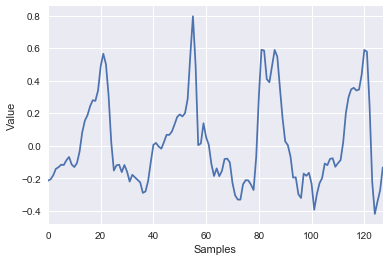

In [19]:
df.loc[0].plot()
plt.xlabel('Samples')
plt.ylabel('Value');

## Prep data for feature building
We need to get the data in the format required by TSFRESH:

If there are 100 examples, where each example has 50 samples, we need to go from a (100, 50) dataframe to a (100*50, 2) dataframe as follows:
~~~
measurement|example_id
----------------------
0.5235     |0
0.4284     |0
0.9042     |0
...
0.9042     |100
~~~
See the TSFRESH docs for more details

In [21]:
# values
v = df.stack().values

# ids
ids = []
for i in range(len(y)):
    ids.extend(128*[i])
ids = np.array(ids)

master_df = pd.DataFrame(v, columns=['measurement'])
master_df['example_id'] = ids

## Build Train/Test Set

In [22]:
# build label dataframe
label_df = pd.DataFrame(y.reset_index(drop=True))\
    .reset_index()
label_df.columns = ['example_id', 'label']

# split into training and test 
train_id, test_id = train_test_split(label_df.example_id, random_state=43, test_size=0.2)
train_id = pd.DataFrame(train_id)
test_id  = pd.DataFrame(test_id)

data_train = master_df.merge(train_id, on='example_id')
data_test = master_df.merge(test_id, on='example_id')
print float(data_train.shape[0])/(data_train.shape[0] + data_test.shape[0])

label_train = label_df.merge(train_id, on='example_id')
label_test = label_df.merge(test_id, on='example_id')

0.799902865469


## Build a model

In [23]:
%%time

extraction_settings = MinimalFCParameters()

X_train = extract_features(data_train, column_id='example_id', impute_function=eval('tsfresh.utilities.dataframe_functions.impute'), default_fc_parameters=extraction_settings); 
X_test  = extract_features(data_test, column_id='example_id', impute_function=impute, default_fc_parameters=extraction_settings); 

Feature Extraction: 100%|██████████| 412/412 [00:00<00:00, 3297.11it/s]

CPU times: user 670 ms, sys: 115 ms, total: 786 ms
Wall time: 947 ms


In [26]:
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score
tpot = TPOTClassifier(verbosity=2, max_time_mins=.5)
tpot.fit(X_train, label_train.label)
roc_auc_score(label_test.label, tpot.predict_proba(X_test)[:,1])


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: LogisticRegression(input_matrix, LogisticRegression__C=25.0, LogisticRegression__dual=DEFAULT, LogisticRegression__penalty=DEFAULT)


0.9443151595744681

### Compare to Random Forest (baseline)

In [27]:
from sklearn.ensemble import RandomForestClassifier
cl = RandomForestClassifier(n_estimators=100, n_jobs=-1)
cl.fit(X_train, label_train.label)
roc_auc_score(label_test.label, cl.predict_proba(X_test)[:,1])

0.94799582066869303

/Users/crawles/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


,importances
features,
measurement__length,0.000000
measurement__mean,0.046362
measurement__sum_values,0.048065
measurement__minimum,0.068785
measurement__variance,0.162035
measurement__median,0.176112
measurement__standard_deviation,0.207371
measurement__maximum,0.291270


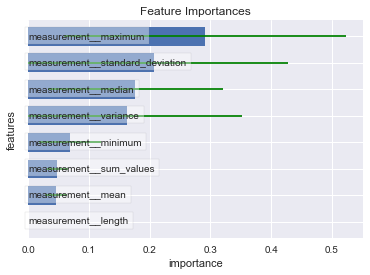

In [28]:
def plot_importances(cl, column_names, n_features=10, ax=None, error_bars = True):
    df_imp = pd.DataFrame({'features': column_names,
                           'importances': cl.feature_importances_})
    errors = np.std([tree.feature_importances_ for tree in cl.estimators_], axis=0)
    df_imp_sub = df_imp.set_index('features').sort_values('importances').tail(n_features)
    if error_bars:
        df_errors = pd.DataFrame({'features': column_names,
                                  'importances': errors})
        df_err_sub = df_errors.set_index('features').ix[df_imp_sub.index]
    else:
        df_err_sub = None
    ax = df_imp_sub.plot(kind='barh', width=.7, legend=False, ax=ax, xerr=df_err_sub, ecolor='g')
    for i,t in enumerate(df_imp_sub.index.tolist()):
        t = ax.text(0.001, i-.06,t)
        t.set_bbox(dict(facecolor='white', alpha=0.4, edgecolor='grey'))
    ax.yaxis.set_major_formatter(plt.NullFormatter())
    ax.set_title('Feature Importances')
    ax.set_xlim(0.0)
    ax.set_xlabel('importance')
    return df_imp_sub

plot_importances(cl, X_train.columns)

## Export Data
Save training/testing data so we can build and test the AutoML Flask service

In [236]:
import os
output_dir = 'automl_service/data'
data_train.to_json(os.path.join(output_dir, 'data_train.json'))
data_test.to_json(os.path.join(output_dir, 'data_test.json'))
label_train.to_json(os.path.join(output_dir, 'label_train.json'))
label_test.to_json(os.path.join(output_dir, 'label_test.json'))

# Get Model Results

In [278]:
# models tried and model results
tpot.evaluated_individuals_

# number of models
len(tpot.evaluated_individuals_)

226

## See how different models performed

In [269]:
def get_model_results(evaluated_individuals):
    """For processing model run results, store results as dictionary of AUCS"""
    tpot_results = []
    for i,(k, (steps, auc)) in enumerate(evaluated_individuals.iteritems()):
        model_type = k.split('(')[0]
        tpot_results.append([model_type, i, auc])
    return tpot_results
automl_results = get_model_results(tpot.evaluated_individuals_)
automl_results = pd.DataFrame(automl_results, columns=['model', 'id', 'auc']).sort_values('model')

In [277]:
automl_results.groupby('model').count()

,id,auc
model,,
BernoulliNB,9,9
DecisionTreeClassifier,5,5
ExtraTreesClassifier,109,109
GaussianNB,13,13
GradientBoostingClassifier,1,1
KNeighborsClassifier,23,23
LinearSVC,15,15
LogisticRegression,25,25
MultinomialNB,5,5


## Build BoxPlot

(0.8, 0.90000000000000002)

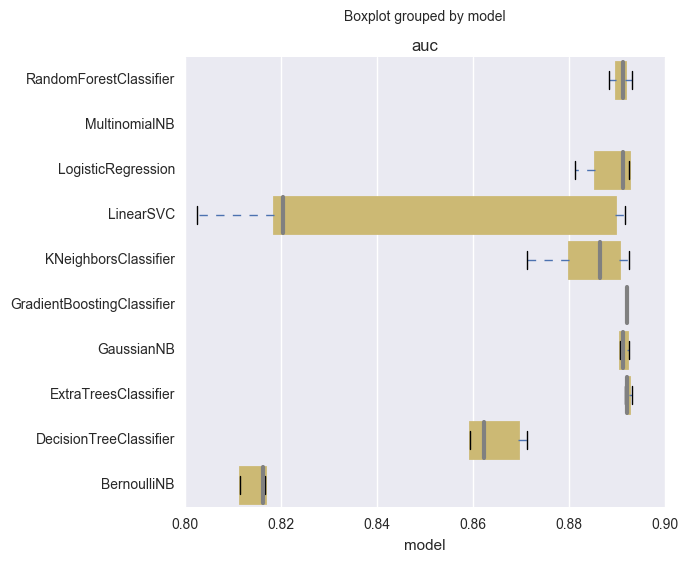

In [279]:
import seaborn
sns.set_style(style='darkgrid')
f, ax = plt.subplots(figsize=(6,6))
box = automl_results.boxplot(column='auc', by='model', rot=0, vert=False,
                             ax=ax, patch_artist=True, return_type='dict',
                             widths=0.8)
ax.grid(axis='y')

for b in box['auc']['boxes']:
    color = sns.color_palette()[4] 
    b.set(color=color, linewidth=2)
    b.set(facecolor=color, linewidth=2)

# for median in bp['medians']:
for median in box['auc']['medians']:
    median.set(color='grey', linewidth=3)

plt.xlim(0.8)

TypeError: 'AxesSubplot' object has no attribute '__getitem__'

In [150]:
pd.DataFrame(model_types)

ValueError: arrays must all be same length

# Test API 

## Train Model

In [246]:
!ls 

ls: data: No such file or directory


In [245]:
import os
import requests
base_url = "http://0.0.0.0:8080"
train_url = os.path.join(base_url, 'train_model')
serve_url = os.path.join(base_url, 'serve_pred')

train_files =  files = {'raw_data': ('data/train_data', open('report.xls', 'rb'),
                        'application/vnd.ms-excel', {'Expires': '0'})}
requests.post(train_url)